In [1]:
import gnss_tid.pointdata
import xarray as xr
import subprocess, os
import numpy as np
from scipy import ndimage
from astropy.convolution import convolve, Gaussian2DKernel
from datetime import datetime, timedelta
from argparse import ArgumentParser
import matplotlib.pyplot as plt
import warnings, re

warnings.filterwarnings('ignore')

/homes/mraks1/software/gnss-tid/.venv/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [13]:
def getNeighbours(image,i,j,N=3):
    """
    Return an array of <=9 neighbour pixel of an image with a center at (i,j)
    """
    nbg = []
    m = int(np.floor(N/2))
    M = int(np.ceil(N/2))
    for k in np.arange(i-m, i+M):
        for l in np.arange(j-m, j+M):
            try:
                nbg.append(image[k,l])
            except:
                pass
    return np.array(nbg)

def fillPixels(im, N=1):
    """
    Fill in the dead pixels. If a dead pixel has a least 4 finite neighbour
    pixel, than replace the center pixel with a mean valuse of the neighbours
    """
    X = im.shape[0]-1
    Y = im.shape[1]-1
    imcopy = np.copy(im)
    for n in range(N):
        skip = int(np.floor((3+n)/2))
        starti = 0
        startj = 0
        forwardi = int(np.floor(0.7*X))
        backwardi = int(np.floor(0.3*X))
        if n%2 == 0:
            for i in np.arange(starti, forwardi, skip):
                for j in np.arange(startj, Y, skip):
                    # Check if th epixel is dead, i.e. empty
                    if np.isnan(im[i,j]):
                        # Get its neighbours as a np array
                        nbg = getNeighbours(imcopy,i,j,N=(3+n))
                        # If there are at leas 4 neighbours, replace the value with a mean
                        if sum(np.isfinite(nbg)) >= 4:
                            ix = np.where(np.isfinite(nbg))[0]
                            avg = np.median(nbg[ix])
                            im[i,j] = avg
            for i in np.arange(X, backwardi, -skip):
                for j in np.arange(Y, 0, -skip):
                    # Check if th epixel is dead, i.e. empty
                    if np.isnan(im[i,j]):
                        # Get its neighbours as a np array
                        nbg = getNeighbours(imcopy,i,j,N=(3+n))
                        # If there are at leas 4 neighbours, replace the value with a mean
                        if sum(np.isfinite(nbg)) >= 4:
                            ix = np.where(np.isfinite(nbg))[0]
                            avg = np.median(nbg[ix])
                            im[i,j] = avg
        else:
            for j in np.arange(startj, Y, skip):
                for i in np.arange(starti, forwardi, skip):
                    # Check if th epixel is dead, i.e. empty
                    if np.isnan(im[i,j]):
                        # Get its neighbours as a np array
                        nbg = getNeighbours(imcopy,i,j,N=(3+n))
                        # If there are at leas 4 neighbours, replace the value with a mean
                        if sum(np.isfinite(nbg)) >= 4:
                            ix = np.where(np.isfinite(nbg))[0]
                            avg = np.median(nbg[ix])
                            im[i,j] = avg

            for j in np.arange(Y, 0, -skip):
                for i in np.arange(X, backwardi, -skip):
                    # Check if th epixel is dead, i.e. empty
                    if np.isnan(im[i,j]):
                        # Get its neighbours as a np array
                        nbg = getNeighbours(imcopy,i,j,N=(3+n))
                        # If there are at leas 4 neighbours, replace the value with a mean
                        if sum(np.isfinite(nbg)) >= 4:
                            ix = np.where(np.isfinite(nbg))[0]
                            avg = np.mean(nbg[ix])
                            im[i,j] = avg
    return im

def variance_weighted_mean(x, var):
    """
    Compute inverse-variance weighted mean and its variance.
    Parameters
    ----------
    x : array_like
        Observations.
    var : array_like
        Variances associated with each observation.

    Returns
    -------
    mean : float
        Variance-weighted mean.
    mean_var : float
        Variance of the weighted mean.
    """
    x = np.asarray(x, dtype=float)
    var = np.asarray(var, dtype=float)

    w = 1.0 / np.square(var)                   # inverse-variance weights
    mean = np.sum(w * x) / np.sum(w)
    mean_var = 1.0 / np.sum(w)      # variance of the weighted mean

    return mean, mean_var

def ImageNew(glon, glat, tid, variance,
            latlim=None, lonlim=None, 
            res=None, filter_type='median', filter_size=3,
            sigma=2):
    """
    """
    xgrid, ygrid = np.meshgrid(np.arange(lonlim[0], lonlim[1]+.01, res),
                                np.arange(latlim[0], latlim[1]+.01, res))
    im = np.empty(xgrid.shape, dtype=object)
    var = np.empty(xgrid.shape, dtype=object)
    cnt = np.zeros(xgrid.shape, dtype=int)
    # Fill out the image pixels
    for i in range(glon.size):
        idx = abs(xgrid[0, :] - glon[i]).argmin() if abs(xgrid[0, :] - glon[i]).min() < 3*res else np.nan
        idy = abs(ygrid[:, 0] - glat[i]).argmin() if abs(ygrid[:, 0] - glat[i]).min() < 3*res else np.nan
        # If image indexes are valid
        if np.isfinite(idx) and np.isfinite(idy):
            # Assign the value to the pixel
            if im[idy,idx] is None:
                im[idy,idx] = [tid[i]]
                var[idy,idx] = [variance[i]]
            # If this is not the first value to assign, assign a
            # mean of both values
            else:
    #                im[idy, idx] = np.nanmedian( [im[idy, idx], + tid[i]])
                im[idy,idx].append(tid[i])
                var[idy,idx].append(variance[i])
            cnt[idy,idx] += 1

    imout = np.nan * np.empty(xgrid.shape)
    varout = np.nan * np.empty(xgrid.shape)
    for i in range(xgrid.shape[0]):
        for j in range(xgrid.shape[1]):
            if im[i,j] is not None:
                # imout[i,j] = np.nanmedian(im[i,j])
                imout[i,j], varout[i,j] = variance_weighted_mean(im[i,j], var[i,j])           
    #    
    if filter_type == 'median':
        imout = fillPixels(imout)
        imout = ndimage.median_filter(imout, filter_size)
    elif filter_type == 'gaussian':
        kernel = Gaussian2DKernel(x_stddev=sigma, y_stddev=sigma, x_size=filter_size, y_size=filter_size)
        imout = convolve(imout, kernel)
        varout = convolve(varout, kernel)
        
        imout[:filter_size, :] = np.nan
        imout[:, :filter_size] = np.nan
        imout[-filter_size:, :] = np.nan
        imout[:, -filter_size:] = np.nan
        
        varout[:filter_size, :] = np.nan
        varout[:, :filter_size] = np.nan
        varout[-filter_size:, :] = np.nan
        varout[:, -filter_size:] = np.nan
    else:
        imout = fillPixels(imout)
    del im
    return xgrid, ygrid, imout, varout, cnt

In [3]:
folder = "/disk1/tid/sharon/poly/2021/0101/"
latlim = [-90, 90]
lonlim = [-180, 180]
el_mask = 30
res = 0.15
avg = 10
skip = 10
ipp_alt = 250
filter = "gaussian"
sigma1, sigma2, sigma3 = (0.75, 1, 1)
filter_size1, filter_size2, filter_size3 = (5,7,7)
datefmt = re.search(r'(\d{4})/(\d{4})', folder).group(0)
tlim = [datetime.strptime(datefmt, "%Y/%m%d").strftime("%Y%m%d_0000"), (datetime.strptime(datefmt, "%Y/%m%d")+timedelta(days=1)).strftime("%Y%m%d_0000")]


In [4]:
points = gnss_tid.pointdata.PointData(
  folder + "*.nc",
  latitude_limits=latlim,
  longitude_limits=lonlim,
  time_limits=tlim,
  el_min=el_mask,
  q_thresh=.95,
  noise_max=10,
)
time_slices, times = points.get_time_slices(10, 10)

loading files:   0%|          | 0/5010 [00:00<?, ?it/s]

In [11]:
print (len(time_slices))
print (time_slices)

288
[slice(0, 10, None), slice(10, 20, None), slice(20, 30, None), slice(30, 40, None), slice(40, 50, None), slice(50, 60, None), slice(60, 70, None), slice(70, 80, None), slice(80, 90, None), slice(90, 100, None), slice(100, 110, None), slice(110, 120, None), slice(120, 130, None), slice(130, 140, None), slice(140, 150, None), slice(150, 160, None), slice(160, 170, None), slice(170, 180, None), slice(180, 190, None), slice(190, 200, None), slice(200, 210, None), slice(210, 220, None), slice(220, 230, None), slice(230, 240, None), slice(240, 250, None), slice(250, 260, None), slice(260, 270, None), slice(270, 280, None), slice(280, 290, None), slice(290, 300, None), slice(300, 310, None), slice(310, 320, None), slice(320, 330, None), slice(330, 340, None), slice(340, 350, None), slice(350, 360, None), slice(360, 370, None), slice(370, 380, None), slice(380, 390, None), slice(390, 400, None), slice(400, 410, None), slice(410, 420, None), slice(420, 430, None), slice(430, 440, None), sli

In [ ]:
i = 100
# for i in range(len(time_slices)):
    # print (f"{i+1}/{len(times)}, Processing {times[i]}")
point_data = points.get_data(time_slices[i], h=ipp_alt, use_local_cs=0)
grid, ygrid, imout1, varout, cnt = ImageNew(point_data.lon.values, 
                                            point_data.lat.values, 
                                            point_data.dtec1.values, 
                                            point_data.tec_noise.values, 
                                            latlim=latlim, lonlim=lonlim, res=res, filter_type=filter, 
                                            filter_size=filter_size1, sigma=sigma1)
xgrid, ygrid, imout2, varout, cnt = ImageNew(point_data.lon.values, 
                                            point_data.lat.values, 
                                            point_data.dtec2.values, 
                                            point_data.tec_noise.values, 
                                            latlim=latlim, lonlim=lonlim, res=res, filter_type=filter, 
                                            filter_size=filter_size2, sigma=sigma2)
xgrid, ygrid, imout3, varout, cnt = ImageNew(point_data.lon.values, 
                                            point_data.lat.values, 
                                            point_data.dtec3.values, 
                                            point_data.tec_noise.values, 
                                            latlim=latlim, lonlim=lonlim, res=res, filter_type=filter, 
                                            filter_size=filter_size3, sigma=sigma3)
# xgrid, ygrid, imout, varout, cnt = ImageNew(point_data.lon.values, 
#                                             point_data.lat.values, 
#                                             point_data.dtec3.values, 
#                                             point_data.tec_noise.values, 
#                                             latlim=latlim, lonlim=lonlim, res=res, filter_type=None, 
#                                             filter_size=filter_size3, sigma=sigma3)


In [17]:
print (point_data)

<xarray.Dataset> Size: 2MB
Dimensions:    (los_id: 23327)
Coordinates:
  * los_id     (los_id) int64 187kB 10 11 12 14 ... 175256 175259 175260 175261
Data variables: (12/13)
    az         (los_id) float64 187kB 81.73 93.59 161.6 ... 57.34 261.0 320.3
    el         (los_id) float64 187kB 52.71 53.37 72.81 ... 79.72 45.52 37.36
    dtec0      (los_id) float64 187kB -0.006431 0.008278 ... -0.007356 -0.01929
    dtec1      (los_id) float64 187kB 0.03782 0.03643 ... 0.09225 -0.0679
    dtec2      (los_id) float64 187kB 0.1734 0.1304 -0.08668 ... 0.2333 -0.1182
    dtec3      (los_id) float64 187kB 0.3382 0.2651 -0.1183 ... 0.4095 -0.1838
    ...         ...
    tec_noise  (los_id) float64 187kB 7.725 6.225 5.576 ... 5.016 6.092 5.048
    tec_snr    (los_id) float64 187kB 47.85 48.05 51.1 50.75 ... 47.25 44.2 45.9
    rx         (los_id) int64 187kB 0 0 0 0 1 1 ... 5001 5002 5002 5002 5002
    sv         (los_id) object 187kB 'G20' 'G23' 'G10' ... 'G05' 'G25' 'G29'
    lat        (los_id)

In [23]:
O = xr.Dataset(coords={"lon": (["lat","lon"], xgrid), "lat": (["lat","lon"], ygrid),
                       "ipp_lon": point_data.lon.values, "ipp_lat": point_data.lat.values,
                       },
                  data_vars={"dtec30": (["ipp"], point_data.dtec1.values),
                             "dtec60": (["ipp"], point_data.dtec2.values),
                             "dtec90": (["ipp"], point_data.dtec3.values),
                             "dtec30grid": (["lat", "lon"], imout1),
                             "dtec60grid": (["lat", "lon"], imout2),
                             "dtec90grid": (["lat", "lon"], imout3),})
attrs = {
  "filter": filter,
  "filter_size30": filter_size1,
  "filter_size60": filter_size2,
  "filter_size90": filter_size3,
  "filter_sigma30": sigma1,
  "filter_sigma60": sigma2,
  "filter_sigma90": sigma3,
  "resolution": res,
  "ipp_altkm": ipp_alt,
  "el_mask": el_mask,
  "author": "smrak",
  "processed:": datetime.now(),

}
O.assign_attrs(attrs)
# O["filter"] = filter
# O["filter_size30"] = filter_size1
# O["filter_size60"] = filter_size2
# O["filter_size90"] = filter_size3
# O["filter_sigma30"] = sigma1
# O["filter_sigma60"] = sigma2
# O["filter_sigma90"] = sigma3
# O["resolution"] = res
# O["ipp_altkm"] = ipp_alt
# O["el_mask"] = el_mask

<xarray.Dataset> Size: 116MB
Dimensions:     (ipp: 23327, lat: 1201, lon: 2401, ipp_lon: 23327,
                 ipp_lat: 23327)
Coordinates:
    lat         (lat, lon) float64 23MB -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
    lon         (lat, lon) float64 23MB -180.0 -179.8 -179.7 ... 179.9 180.0
  * ipp_lon     (ipp_lon) float32 93kB 177.7 177.6 175.9 ... -98.75 -98.45
  * ipp_lat     (ipp_lat) float32 93kB -39.03 -39.36 -39.92 ... 32.22 34.67
Dimensions without coordinates: ipp
Data variables:
    dtec30      (ipp) float64 187kB 0.03782 0.03643 -0.01182 ... 0.09225 -0.0679
    dtec60      (ipp) float64 187kB 0.1734 0.1304 -0.08668 ... 0.2333 -0.1182
    dtec90      (ipp) float64 187kB 0.3382 0.2651 -0.1183 ... 0.4095 -0.1838
    dtec30grid  (lat, lon) float64 23MB nan nan nan nan nan ... nan nan nan nan
    dtec60grid  (lat, lon) float64 23MB nan nan nan nan nan ... nan nan nan nan
    dtec90grid  (lat, lon) float64 23MB nan nan nan nan nan ... nan nan nan nan
Attributes:
    filter:          gaussian
    filter_size30:   5
    filter_size60:   7
    filter_size90:   7
    filter_sigma30:  0.75
    filter_sigma60:  1
    filter_sigma90:  1
    resolution:      0.15
    ipp_altkm:       250
    el_mask:         30
    author:          smrak
    processed::      2026-02-11 16:34:40.425603

In [24]:
print (O)

<xarray.Dataset> Size: 116MB
Dimensions:     (ipp: 23327, lat: 1201, lon: 2401, ipp_lon: 23327,
                 ipp_lat: 23327)
Coordinates:
    lat         (lat, lon) float64 23MB -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
    lon         (lat, lon) float64 23MB -180.0 -179.8 -179.7 ... 179.9 180.0
  * ipp_lon     (ipp_lon) float32 93kB 177.7 177.6 175.9 ... -98.75 -98.45
  * ipp_lat     (ipp_lat) float32 93kB -39.03 -39.36 -39.92 ... 32.22 34.67
Dimensions without coordinates: ipp
Data variables:
    dtec30      (ipp) float64 187kB 0.03782 0.03643 -0.01182 ... 0.09225 -0.0679
    dtec60      (ipp) float64 187kB 0.1734 0.1304 -0.08668 ... 0.2333 -0.1182
    dtec90      (ipp) float64 187kB 0.3382 0.2651 -0.1183 ... 0.4095 -0.1838
    dtec30grid  (lat, lon) float64 23MB nan nan nan nan nan ... nan nan nan nan
    dtec60grid  (lat, lon) float64 23MB nan nan nan nan nan ... nan nan nan nan
    dtec90grid  (lat, lon) float64 23MB nan nan nan nan nan ... nan nan nan nan


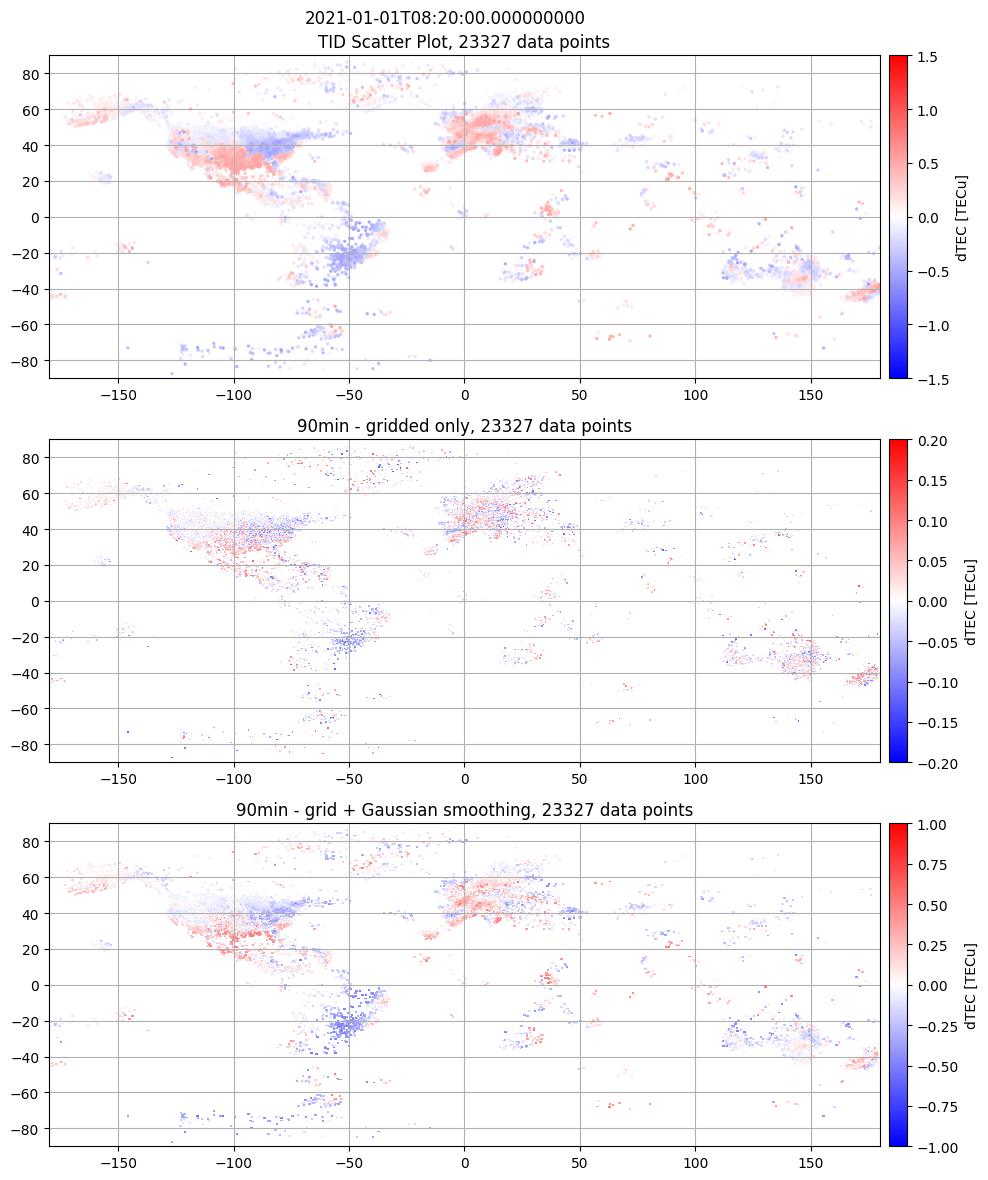

In [26]:
fig = plt.figure(figsize=[9,12])
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312, sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(313, sharex=ax1, sharey=ax1)
# ax4 = fig.add_subplot(414)
ax1.set_xlim(lonlim)
ax2.set_ylim(latlim)

plt.suptitle(f"{point_data.time}")
ax1.set_title(f"TID Scatter Plot, {np.nansum(point_data.dtec3.values.size)} data points")
ax2.set_title(f"90min - gridded only, {np.nansum(point_data.dtec3.values.size)} data points")
ax3.set_title(f"90min - grid + Gaussian smoothing, {np.nansum(point_data.dtec3.values.size)} data points")


order = np.argsort(abs(point_data.dtec3.values))
im1 = ax1.scatter(point_data.lon.values[order], point_data.lat.values[order], c=point_data.dtec3.values[order], cmap='bwr', vmin=-1.5, vmax=1.5, s=2)
im2 = ax2.pcolormesh(xgrid, ygrid, imout1, cmap='bwr', vmin=-.2, vmax=.2)
im3 = ax3.pcolormesh(xgrid, ygrid, imout3, cmap='bwr', vmin=-1, vmax=1)

ax1.grid()
ax2.grid()
ax3.grid()

plt.tight_layout()

posn = ax1.get_position()
cax = fig.add_axes([posn.x0+posn.width+0.01, posn.y0, 0.02, posn.height])
fig.colorbar(im1, cax=cax, label='dTEC [TECu]')
posn = ax2.get_position()
cax = fig.add_axes([posn.x0+posn.width+0.01, posn.y0, 0.02, posn.height])
fig.colorbar(im2, cax=cax, label='dTEC [TECu]')
posn = ax3.get_position()
cax = fig.add_axes([posn.x0+posn.width+0.01, posn.y0, 0.02, posn.height])
fig.colorbar(im3, cax=cax, label='dTEC [TECu]')